# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

##### Author Ian Whittal
 

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.



## Import Libraries

In [2]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage
%matplotlib inline

---
## Load The Data

In [3]:
# Load pickled data
# import pickle

# Reference location of saved the training, validation and testing data

training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f: # rb -> (r) read only and (b) opens the file in binary mode.
    train = pickle.load(f) # train is a dictionary
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f) # valid is a dictionary
with open(testing_file, mode='rb') as f:
    test = pickle.load(f) # test is a dictionary

# Numpy Arrays
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Check to ensure features equals labels for each data set
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# Print shapes of training, validation and test data

print("X_train shape:", X_train[0].shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid[0].shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test[0].shape)
print("y_test shape:", y_test.shape)


X_train shape: (32, 32, 3)
y_train shape: (34799,)
X_valid shape: (32, 32, 3)
y_valid shape: (4410,)
X_test shape: (32, 32, 3)
y_test shape: (12630,)


---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Basic Summary of the Data Set Using Python, Numpy

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# hat's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset. python np.unique() returns unique in array, use training dataset as it will have all labels
n_classes = len(np.unique(y_train)) 

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Shape of first training image =", image_shape[0], "w x", image_shape[1], "h x ", image_shape[2], "d")
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Shape of first training image = 32 w x 32 h x  3 d
Number of classes = 43


### Exploratory Visualization of the Dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).  From the visualization we can clearly see this is a large amount of training data, however there is very little validation data.  The test data seems appropriate enough to test our classifier on.   

The histogram below shows an overlay of each data set across each of the 43 different sign classes.  Of additional note is that there are limited images available for individual classes, which may make those images harder to classify accurately.  I will want to use data augmentation to create more images overall for training.


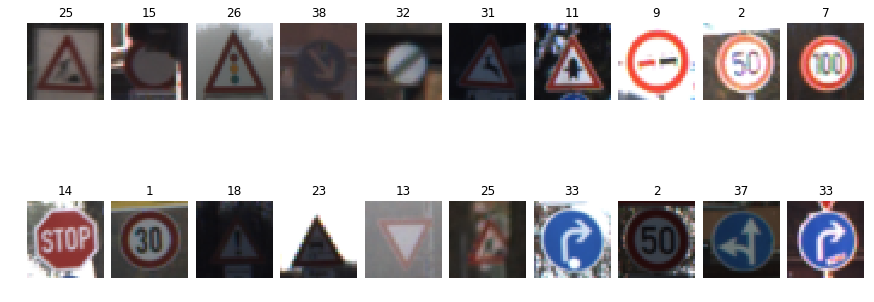

In [5]:

# Show visualations of dataset


fig, axs = plt.subplots(2,10, figsize=(15, 6)) 
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
for i in range(20):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

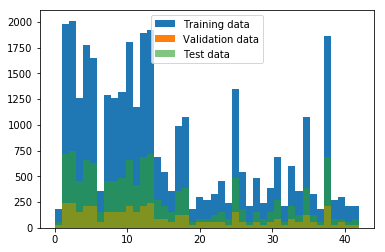

In [6]:
# Histogram of Image Class Distribution

a = y_train
b = y_valid
c = y_test
bins = n_classes

plt.hist(a, bins, alpha = 1.0, label='Training data')
plt.hist(b, bins, alpha = 1.0, label='Validation data')
plt.hist(c, bins, alpha = 0.6, label='Test data')
plt.legend(loc='upper center')

plt.show()

----

## Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## Data Augmentation (Rotation)

In [7]:
## Data augmentation technique: Rotate training images
degrees = 10

# Rotating images
degrees_positive = 10
X_train_rotated_positive = []

for i in range(len(X_train)):
    rotated_image = scipy.ndimage.rotate(X_train[i], degrees_positive)
    X_train_rotated_positive.append(rotated_image)
    
degrees_negative = 350
X_train_rotated_negative = []
for i in range(len(X_train)):
    rotated_image = scipy.ndimage.rotate(X_train[i], degrees_negative)
    X_train_rotated_negative.append(rotated_image)    

# Crop image, due to other image size after rotation. Attention: it's not automated! It fit's currently to the 10° rotation.
for i in range(len(X_train_rotated_positive)):
    X_train_rotated_positive[i] = X_train_rotated_positive[i][2:34,2:34]   # box=(y:y+crop, x:x+crop)

for i in range(len(X_train_rotated_negative)):
    X_train_rotated_negative[i] = X_train_rotated_negative[i][2:34,2:34]   # box=(y:y+crop, x:x+crop)
    
# appending rotated images to training set

# Convert the data into list type to use the method "append"
X_train = list(X_train)

# combine the Lists
for i in range(len(X_train_rotated_positive)):
    X_train.append(X_train_rotated_positive[i])
    X_train.append(X_train_rotated_negative[i])
    
#Convert the data back to a np.array
X_train = np.array(X_train)

# New number of training examples (after data augmentation)
new_n_train = len(X_train)
print("New number of training samples after data augmentation =", new_n_train)


# do the same for the labels y_train
# Convert the data into list type to use the method "append"
y_train = list(y_train)

# lengthen the list
for i in range(len(y_train)):
    y_train.append(y_train[i])
    y_train.append(y_train[i])
    
#Convert the data back to a np.array
y_train = np.array(y_train)

# New length of ground truth labels
new_n_train_y = len(y_train)
print("New length of ground truth labels =", new_n_train_y)

New number of training samples after data augmentation = 104397
New length of ground truth labels = 104397


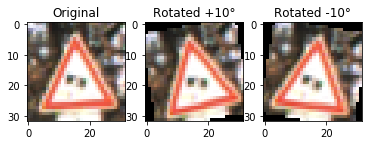

In [8]:
# Display an example for rotation

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(X_train[2018])
ax1.set_title('Original')    
ax1.axis('ON')  # clear x- and y-axes
ax2.imshow(X_train_rotated_positive[2018])
ax2.set_title('Rotated +10°')    
ax2.axis('ON')  # clear x- and y-axes
ax3.imshow(X_train_rotated_negative[2018])
ax3.set_title('Rotated -10°')   
ax3.axis('ON')  # clear x- and y-axes
plt.savefig('./examples/Figure_original_rotated.jpg', dpi=300)
plt.show()

## Pre-process the Data Set (normalization, grayscale, etc.)

###  Shuffle

Shuffle the training data.

In [9]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

print('shuffle complete')

shuffle complete


### Normalizing

Normalizing helps the network to converge faster. It makes it a lot easier for the optimizer to proceed numerically. It is required to normalize the image data so that the data has mean zero and equal variance. Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 127.5)/ 255` will take the pixel  is a quick way to approximately normalize the data and can be used in this project. A well conditioned image allows the optimizer to be more efficient to find a solution. 

### Single-channel images (e.g. grayscale)

As Pierre Sermanet and Yann LeCun mentioned in their [paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), using color channels didn't seem to improve things a lot.  Therefore, I will only use a single channel in my model, e.g. grayscale images instead of color RGB.


Image shape: (32, 32, 1)
10


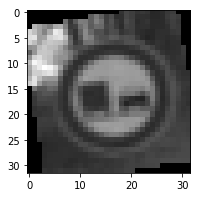

In [10]:
# Normalizing Images for zero mean and equal variance.

X_train = (X_train - 127.5)/255 #pixel range from -1 to 1
X_valid = (X_valid - 127.5)/255
X_test = (X_test - 127.5)/255

# Convert RGB image to grayscale
#X_train_rgb = X_train_grayscale
X_train = np.sum(X_train/3, axis=3, keepdims=True)

#X_valid_rgb = X_valid_grayscale
X_valid = np.sum(X_valid/3, axis=3, keepdims=True)

#X_test_rgb = X_test_grayscale
X_test = np.sum(X_test/3, axis=3, keepdims=True)

print('Image shape:', X_train[0].shape)
#print('Grayscale shape:', X_train_gray[0].shape)

%matplotlib inline
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(3,3))
plt.imshow(image, cmap="gray")
print(y_train[index])

### Model Architecture (Deep Learning Model) Based on LeNet Architecture

![LeNet Architecture](lenet.png)
Source: Yan LeCun

#### Parameters  

To calculate the number of neurons in each layer on our CNN:

Given: 
*  Input Layer has a Width `W` and a Height `H`  
*  Convolution Layer has a Filter size `F`
*  Stride of `S`
*  Padding `P`  Note no padding was neccessary for image library (images are 32x32x3)
*  Number of Filters `K`

Formula:  
*  Width of Next Layer `W_out = [(W - F + 2P) / S] + 1`
*  Height of Next Layer `H_out = [(H - F + 2P) / S] + 1`
*  Output Depth `D_out = K` Number of filters
*  Output Volume `V_out = W_out * H_out * D_out`  

With parameter sharing, each neuron in an output channel shares it's weights with every other neuron in that channel.  So the number of parameters is equal to the number of neurons in the filter, plus a bias neuron, all multiplied by the number of channels in the output layer.

**Remember with weight sharing we use the same filter for an entire depth slice!**

If you have N inputs, & K outputs you have (N+1)K parameters to use.



In [11]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters for tuning
    
    #Agruments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0 # zero mean
    sigma = 0.1 # variance
    
    keep_prob = 0.5 # dropout parameter
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)) #[5,5,1,6] is a 5x5 filter with a input depth of 1 and output depth of 6
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b # strides = [batch, y_direction, x_direction, input_channels]
    print("Shape after 1st convolutional layer: ", conv1.shape)
    
    
    # Activation Function: Rectified Linear Units (ReLU)
    '''The rectified linear activation function or ReLU for short is a piecewise linear function that will output the 
    input directly if it is positive, otherwise, it will output zero. The sigmoid and hyperbolic tangent activation 
    functions cannot be used in networks with many layers due to the vanishing gradient problem.
    The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster 
    and perform better.'''
    conv1 = tf.nn.relu(conv1)

    # Subsampling - Pooling - Max Pooling. Input = 28x28x6. Output = 14x14x6.
    '''A pooling layer is generally used to:
        * Decrease the size of the output
        * Prevent Overfitting'''
    
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID') # 2x2 Kernal. 2x2 Stride
    print("Shape after 1st pooling: ", conv1.shape)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    print("Shape after 2nd convolutional layer: ", conv2.shape)
    
    # Activation Function: Rectified Linear Units (ReLU)
    conv2 = tf.nn.relu(conv2)

    # Subsampling - Pooling - Max Pooling. Input = 10x10x16. Output = 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print("Shape after 2nd pooling: ", conv2.shape)

    # Flatten. Flattens to a vector Input = 5x5x16 = 400, therefore Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    print("Shape after 1st fully connected layer: ", fc1.shape)
    
    # Activation Function: Rectified Linear Units (ReLU)
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    print("Shape after 2nd fully connected layer: ", fc2.shape)
    
    # Activation Function: Rectified Linear Units (ReLU)
    fc2    = tf.nn.relu(fc2)
    
    # Regularization: Dropout
    '''Dropout is a regularization technique for reducing overfitting.  The technique temporarily drops units (artificial neurons) from
    from the network, along with all of those units incoming and outgoing connections'''
    fc2 = tf.nn.dropout(fc2, keep_prob)
    print("Shape after dropout: ", fc2.shape)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    print("Shape of Logits after 3rd fully connected layer: ", logits.shape)
    
    return logits

print('completed')

completed


## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Setup Hyperparameters

`EPOCHS` tells TensorFlow how many times to run our training data through the network in general the more epochs, the better our model will train but also the longer training will take.  

`BATCH_SIZE` tells TensorFlow how many training images to run through the network at a time the larger the batch size, the faster our model will train, but our processor may have a memory limit on how large a batch it can run.

`rate` learning rate tells TensorFlow how quickly to update the network's weights; 0.001 is a good default value but can be experimented with.

In [12]:
EPOCHS = 50 

BATCH_SIZE = 100 

rate = 0.001 


### Features and Labels
Train our modified LeNet CNN to classify training data.

`x` is a placeholder for a batch of input images. Initalize the batch size to `None` which allows the placeholder to later accept a batch of any size.  

`y` is a placeholder for a batch of output labels. Initially our `y` labels come through with sparce variables, which means they are integers and not `one-hot` encoded yet.

`one_hot_y` is a one-hot-label, a 1D list that is 'n' length of the classes

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1)) # images
y = tf.placeholder(tf.int32, (None)) # labels
one_hot_y = tf.one_hot(y, 43) # One-hot label encode each of the 43 classes

### Training Pipeline
Training pipeline that uses the model to classify the "training" traffic sign data.

`LeNet` pass input date to the LeNet function to calculate our `logits`

The learning `rate` tells TensorFlow how quickly to update the network's weights.

A `logits` function, also known as the log-odds function, is a function that represents probability values from 0 to 1, and negative infinity to infinity. The function is an inverse to the sigmoid function that limits values between 0 and 1 across the Y-axis, rather than the X-axis.

Cross Entropy - After determining our `logits` we need to assign a probability to each label, which can be used to classify the data.  The `softmax function` turns logits into probabilities.  Cross-entropy is just a measure of how different the logits are from the ground truth training labels.

Loss Operation - The `tf.reduce_mean` function averages the cross entropy from all of the training images.

Optimizer - `AdamOptimizer` is a replacement optimization algorithm for stochastic gradient descent (SGD) for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.  We use our hyperparamter `rate` to tune the learning rate here.

Training Operation - The `minimize` function is used on the optimizer which uses backpropagation to update the network and minimize our training loss

In [14]:
rate = 0.001

logits = LeNet(x) # pass the input data to the LeNet function to calculate our logits

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits) # softmax function, compare those
# logits to the ground truth labels and calculate the cross entropy.

loss_operation = tf.reduce_mean(cross_entropy) # averages the CE from all of the training images

optimizer = tf.train.AdamOptimizer(learning_rate = rate) # uses Adam algorithm to minimize the loss function similarly to SGD.

training_operation = optimizer.minimize(loss_operation) # run the minimize function on the optimzier


Shape after 1st convolutional layer:  (?, 28, 28, 6)
Shape after 1st pooling:  (?, 14, 14, 6)
Shape after 2nd convolutional layer:  (?, 10, 10, 16)
Shape after 2nd pooling:  (?, 5, 5, 16)
Shape after 1st fully connected layer:  (?, 120)
Shape after 2nd fully connected layer:  (?, 84)
Shape after dropout:  (?, 84)
Shape of Logits after 3rd fully connected layer:  (?, 43)


### Model Evaluation

Evaluate how well the loss and accuracy of the model for a given dataset.

`correct_prediction` is to measure whether a given prediction is correct by comparing the `logits` prediction to the `one_hot_y` ground truth label.

`accuracy_operation` is to calculate the model's overall accuracy by averaging the individual prediction accuracies.

`evaluate` function takes a dataset as input, sets intial variables `num_examples` and `total_accuracy` and batches to data set to run it through the evaluation pipeline.  The function averages each batch to calculate the total accuracy of the model.



In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE] # batch the dataset
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y}) # accuracy = 1 or 0
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

Run the training data through the training pipeline to train the model.

Before each `EPOCHS`, `shuffle` the training set.

After each `EPOCHS`, measure the loss and accuracy of the validation set.

Save the model after training.


In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS): # EPOCHS is a set hyperparameter
        X_train, y_train = shuffle(X_train, y_train) # shuffle to prevent training data bias
        for offset in range(0, num_examples, BATCH_SIZE): # range(start, stop, step)
            end = offset + BATCH_SIZE
            batch_x = X_train[offset:end] # break training data into batches
            batch_y = y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y}) # train the model on each batch
            
        # at the end of each epoch, we evaluate the model on our validation data
        validation_accuracy = evaluate(X_valid, y_valid)
        
        # also evaluate the model on training data to see if the model is over- or underfitted
        training_accuracy = evaluate(X_train, y_train)
        
        # also evaluate the model on test data (different from validation data)
        test_accuracy = evaluate(X_test, y_test)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Accuracy on the training set = {:.3f}".format(training_accuracy))
        print("Accuracy on the test set = {:.3f}".format(test_accuracy))
        
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    
    saver.save(sess, 'lenet') # save the model to be able to load it up later and modify it or evaluate it on test dataset
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.779
Accuracy on the training set = 0.827
Accuracy on the test set = 0.776

EPOCH 2 ...
Validation Accuracy = 0.865
Accuracy on the training set = 0.906
Accuracy on the test set = 0.851

EPOCH 3 ...
Validation Accuracy = 0.900
Accuracy on the training set = 0.938
Accuracy on the test set = 0.878

EPOCH 4 ...
Validation Accuracy = 0.903
Accuracy on the training set = 0.951
Accuracy on the test set = 0.885

EPOCH 5 ...
Validation Accuracy = 0.913
Accuracy on the training set = 0.961
Accuracy on the test set = 0.893

EPOCH 6 ...
Validation Accuracy = 0.920
Accuracy on the training set = 0.968
Accuracy on the test set = 0.907

EPOCH 7 ...
Validation Accuracy = 0.920
Accuracy on the training set = 0.971
Accuracy on the test set = 0.901

EPOCH 8 ...
Validation Accuracy = 0.938
Accuracy on the training set = 0.978
Accuracy on the test set = 0.909

EPOCH 9 ...
Validation Accuracy = 0.936
Accuracy on the training set = 0.979
Accuracy on the test s

### Test Log

 2021-02-25  

* Test 1 - 94.4 % 
preprocessing: shuffle, normalization  
model: original LeNet, batch size: 128, epochs: 10, rate: 0.001, mu: 0, sigma: 0.1


* Test 2 - 90.3 %
preprocessing: shuffle, normalization 
model: original LeNet plus added a dropout before final 3rd fully connected layer, 
batch size: 128, epochs: 10, rate: 0.001, mu: 0, sigma: 0.1


* Test 3 - 89.0 % 
preprocessing: shuffle, normalization, added grayscale
model: original LeNet plus added a dropout before final 3rd fully connected layer, 
batch size: 128, epochs: 10, rate: 0.001, mu: 0, sigma: 0.1  


* Test 4 - 98.2 %
preprocessing: shuffle, normalization, grayscale
model: original LeNet plus added a dropout before final 3rd fully connected layer, 
batch size: 128, epochs: 50, rate: 0.001, mu: 0, sigma: 0.1
Notes: Changing the number of Epochs improved accuracy greatly, validation accuracy is only 78.3% (overfitting)  


* Test 5 - 98.3 % 
preprocessing: shuffle, normalization, grayscale
model: original LeNet plus added a dropout before final 3rd fully connected layer, 
batch size: 128, epochs: 50, rate: 0.0005, mu: 0, sigma: 0.1
Notes: Changing the learning rate did not improve accuracy, validation accuracy is only 74.5% (overfitting)  


* Test 6 - 98.3 %- Added Data Augmentation to add additional training images (rotated)
preprocessing: shuffle, normalization, grayscale
model: original LeNet plus added a dropout before final 3rd fully connected layer, 
batch size: 128, epochs: 50, rate: 0.001, mu: 0, sigma: 0.1
Notes: Changing the learning rate did not improve accuracy, validation accuracy is only 82.5% (overfitting)  


* Test 7 - 98.0 % - Added Data Augmentation training images (rotated)
preprocessing: shuffle, normalization, grayscale
model: original LeNet plus added a dropout before final 3rd fully connected layer, 
batch size: 128, epochs: 50, rate: 0.001, mu: 0, sigma: 0.1 keep_prob: 0.5 for Dropout
Notes: From Nitish Srivastava [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) "*Dropout probability p independent of other units, where p can be chosen using a validation set or can simply be set at 0.5, which seems to be close to optimal for a wide range of networks and tasks."*  

    
* Test 8 - 99.5% !! Training Accuracy / 94.2 % Validation Accuracy !!!
Added Data Augmentation training images (rotated)
preprocessing: shuffle, normalization (changed normalization to -1 to 1), grayscale
model: original LeNet plus added a dropout before final 3rd fully connected layer, 
batch size: 128, epochs: 50, rate: 0.001, mu: 0, sigma: 0.1 keep_prob: 0.5 for Dropout
Notes: From Nitish Srivastava [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) "<i>Dropout probability p independent of other units, where p can be chosen using a validation set or can simply be set at 0.5, which seems to be close to optimal for a wide range of networks and tasks."  
  
  
* Test 9 - 99.7% !! Training Accuracy / 94.8 % Validation Accuracy !!!     
Same as Test 8, reduced Batch size to 100.  Slight improvement.      

* Test 10 - **99.6% Training Accuracy / Validation Accuracy = 96.1% / 93.1% Test Set Accuracy**


## Test the Model

---

## Test a Model on New Images

To test my model I downloaded (5) German road signs at random.  I wanted to try really unique photos, so I tried to find road signs that are toxic as I read about in the following paper [DARTS: Deceiving Autonomous Cars with Toxic Signs](https://arxiv.org/pdf/1802.06430.pdf).  I wanted to ensure the pictures had some graffiti, poor lighting, I also selected a few images that had a limited training data for that class.


### Load and Output the Images

In [17]:
import numpy as np
import cv2
import glob
import os
from PIL import Image

# Load images from .png files to` NumPy array named X_web
X_web = np.empty([0, 32, 32, 3], dtype = np.float64) # numpy.empty(shape, dtype); shape > int or tuple of int; 

# loading the images into a file list (no numpy array! only a list)
web_file_list = [f for f in glob.glob("signs/" + '*.png')]
 

for i in range(1,6):
    image = cv2.imread('../CarND-Traffic-Sign-Classifier-Project/signs/example_' + str(i) + '.png')
    print("original image has shape: ", image.shape)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(img_rgb, (32, 32))
    print("resized image has shape:  ", image_resized.shape)
    cv2.imwrite('../CarND-Traffic-Sign-Classifier-Project/signs/cv2_'+ str(i) +'.png', image_resized)
    X_web = np.append(X_web, [image_resized[:, :, :3]], axis = 0)



original image has shape:  (2110, 2445, 3)
resized image has shape:   (32, 32, 3)
original image has shape:  (126, 130, 3)
resized image has shape:   (32, 32, 3)
original image has shape:  (380, 382, 3)
resized image has shape:   (32, 32, 3)
original image has shape:  (317, 326, 3)
resized image has shape:   (32, 32, 3)
original image has shape:  (1059, 1204, 3)
resized image has shape:   (32, 32, 3)


In [18]:
# Enter correct labels (groundtruth) for the images found on the web

y_web = np.array([
    14, # "example_1" Stop
    17, # "example_2" No entry
    4, # "example_3" Speed limit (70km/h) 
    19, # "example_4" Dangerous curve to the left     
    0, # "example_5" Speed limit (20km/h) 
])

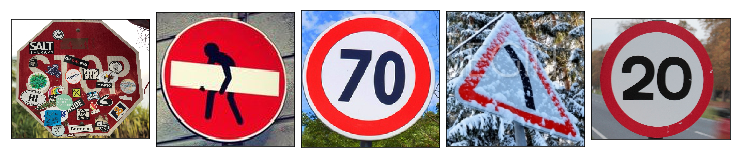

In [23]:
fig = plt.figure()
fig.subplots_adjust(left = 0, right = 2, bottom = 0, top = 2, hspace = 0.05, wspace = 0.05)

for i in range(1,6):
    axis = fig.add_subplot(1, 6, i + 1, xticks=[], yticks=[])
    web_image = Image.open('../CarND-Traffic-Sign-Classifier-Project/signs/example_' + str(i) + '.png')
    axis.imshow(web_image)

## Pre-Process Data (Normalize & Grayscale Image)

In [20]:
# Normalizing Images for zero mean and equal variance.
X_web = (X_web - 127.5)/255 #pixel range from 0 to 1

# Convert RGB image to grayscale
X_web = np.sum(X_web/3, axis=3, keepdims=True)

print("X_web[0].shape: ", X_web[0].shape)
print("X_web.shape: ", X_web.shape)


X_web[0].shape:  (32, 32, 1)
X_web.shape:  (5, 32, 32, 1)


### Accuracy

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    num_examples = len(X_web)
    BATCH_SIZE = 1
    web_accuracy = evaluate(X_web, y_web)
    print("Accuracy on images found on the web = {:.3f}".format(web_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Accuracy on images found on the web = 0.400


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [22]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web.  

top_5_probabilities = tf.nn.top_k(tf.nn.softmax(logits), k=5) # tf.nn.top_k(input, k=?)

keep_prob = 1.0

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('lenet.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    top_5_probabilities_output = sess.run(top_5_probabilities, feed_dict = {x:X_web, y:y_web})
    print(top_5_probabilities_output)

INFO:tensorflow:Restoring parameters from ./lenet
TopKV2(values=array([[  9.98125255e-01,   1.10964314e-03,   7.38309114e-04,
          1.17359086e-05,   1.13102760e-05],
       [  9.99988437e-01,   1.15057510e-05,   2.05401916e-16,
          6.01358253e-24,   4.61087937e-24],
       [  1.00000000e+00,   9.14479047e-15,   5.57972110e-23,
          3.40114940e-30,   3.87947907e-31],
       [  9.70065475e-01,   1.53705040e-02,   7.35882670e-03,
          7.15095829e-03,   4.73097753e-05],
       [  9.99681354e-01,   2.61820242e-04,   5.66043418e-05,
          1.78943637e-07,   6.86999613e-08]], dtype=float32), indices=array([[19, 38,  0,  1, 11],
       [17, 14, 38,  1, 39],
       [ 0,  1, 33, 14,  4],
       [38, 23, 20, 25, 18],
       [ 0, 30, 20, 31, 11]], dtype=int32))


---

## Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [24]:
### Visualize your network's feature maps here.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./lenet


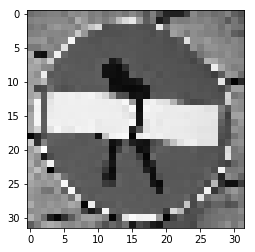

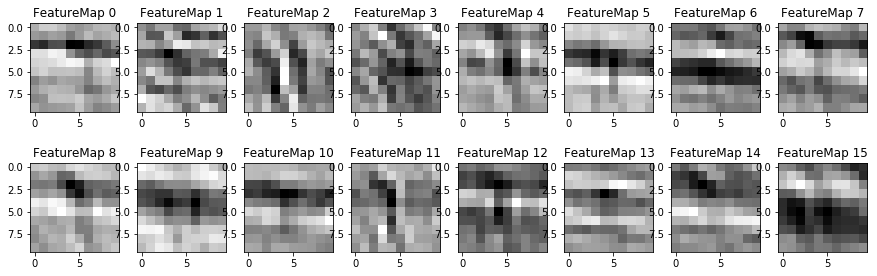

In [37]:
img = np.zeros((1,32,32,3))
img[0,:,:,:] = np.array(Image.open('../CarND-Traffic-Sign-Classifier-Project/signs/example_2.png').resize((32,32)))

#normalize
image_input = (img - 127.5)/255

#grayscale

image_input = np.sum(img/3, axis=3, keepdims=True)

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    conv_1 = tf.get_default_graph().get_tensor_by_name("Conv2D_1:0")

    plt.imshow(np.squeeze(image_input),cmap='gray')
    plt.show()
    outputFeatureMap(image_input, conv_1)